In [2]:
import numpy as np
import ripser
import persim

from matplotlib import pyplot as plt
from sklearn.decomposition import KernelPCA

In [1]:
import sys
print(sys.version)
print(sys.path)
# sys.path.append('path/to/module')

3.9.1 (tags/v3.9.1:1e5d33e, Dec  7 2020, 17:08:21) [MSC v.1927 64 bit (AMD64)]
['c:\\Users\\test\\Downloads\\Telegram Desktop', 'c:\\Users\\test\\.vscode\\extensions\\ms-toolsai.jupyter-2021.3.619093157\\pythonFiles\\.does-not-exist', 'c:\\Users\\test\\.vscode\\extensions\\ms-toolsai.jupyter-2021.3.619093157\\pythonFiles', 'c:\\Users\\test\\.vscode\\extensions\\ms-toolsai.jupyter-2021.3.619093157\\pythonFiles\\lib\\python', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.9_3.9.496.0_x64__qbz5n2kfra8p0\\python39.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.9_3.9.496.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.9_3.9.496.0_x64__qbz5n2kfra8p0\\lib', 'C:\\Users\\test\\AppData\\Local\\Microsoft\\WindowsApps\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0', '', 'C:\\Users\\test\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\

In [3]:
def generate_cylinder(n_points, noise=0):
    z = np.random.rand(n_points)
    alphas = np.random.rand(n_points) * 2 * np.pi
    
    x, y = np.cos(alphas), np.sin(alphas)
    
    return np.stack((x, y, z), axis=1) + noise * np.random.randn(n_points, 3)

### For linear PCA we get the following

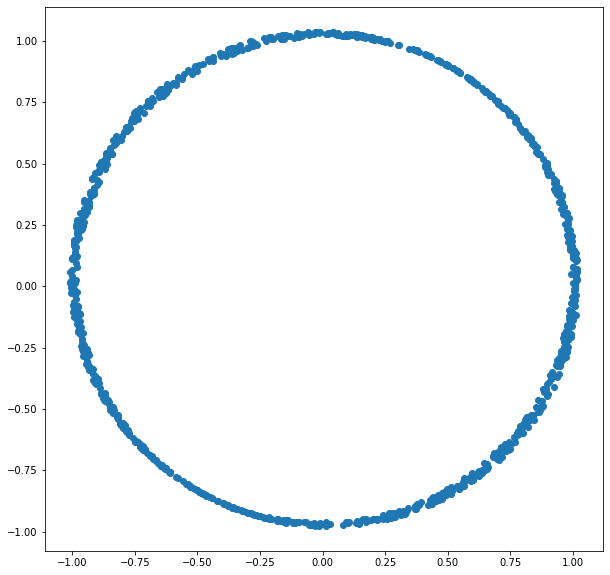

In [4]:
pca = KernelPCA(2)
points = pca.fit_transform(generate_cylinder(1000))

plt.figure(figsize=(10, 10))
plt.scatter(points[:, 0], points[:, 1])
plt.show()

### For kernel PCA with sigmoid kernel we get this parametric family of images

Gamma = 0.1


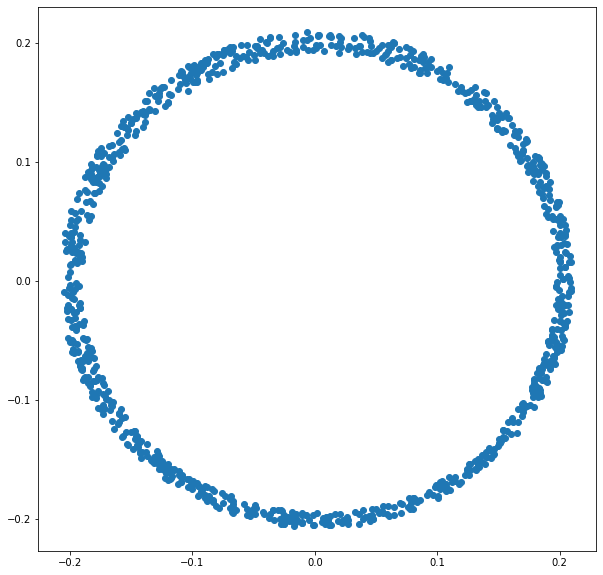

Gamma = 1


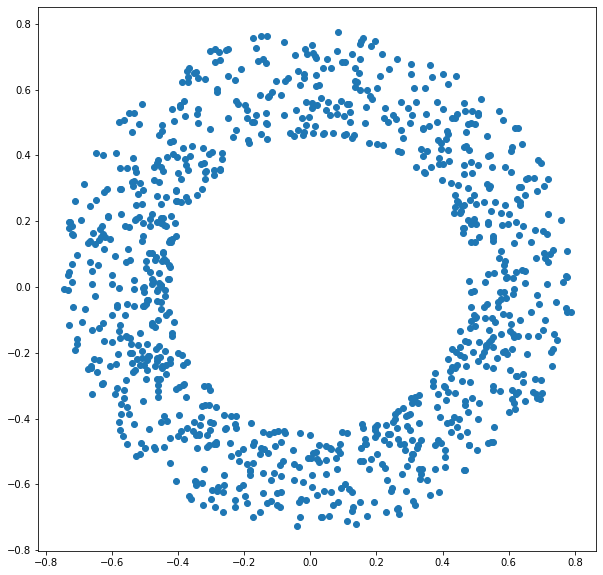

Gamma = 2


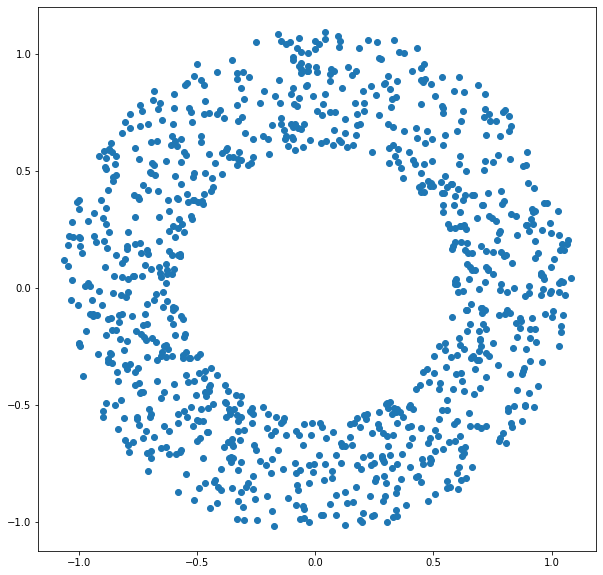

Gamma = 3


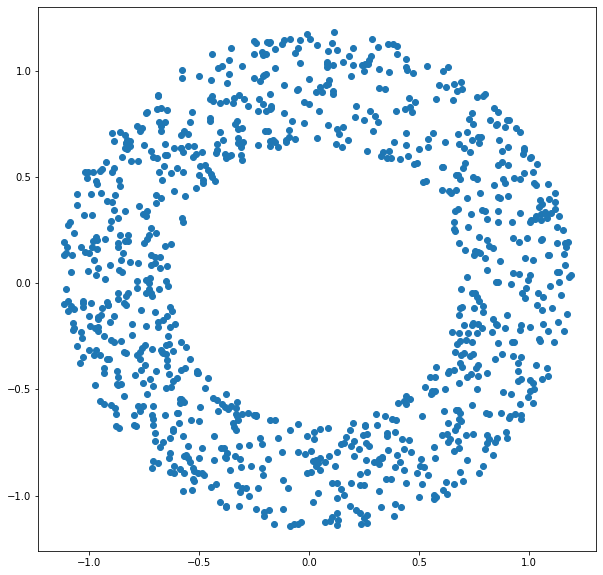

Gamma = 6


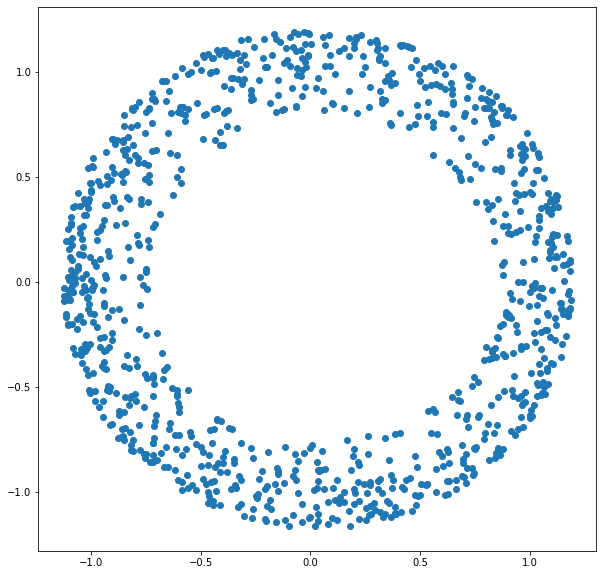

Gamma = 10


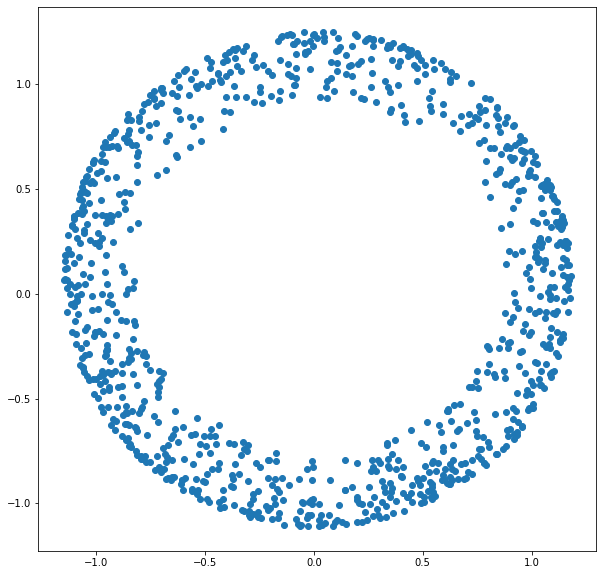

Gamma = 30


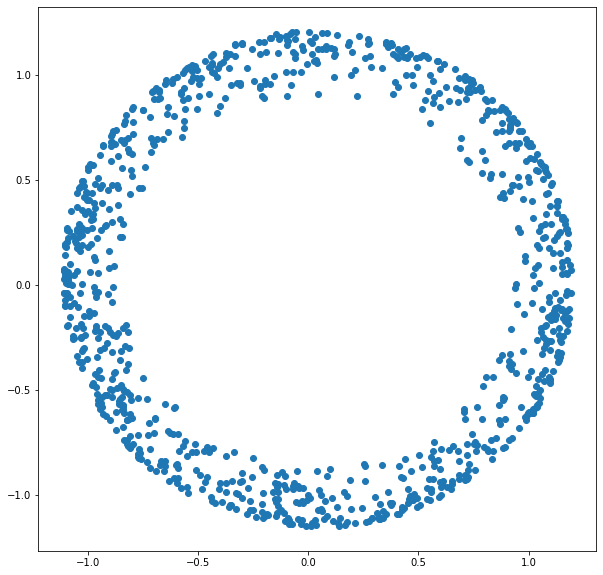

Gamma = 100


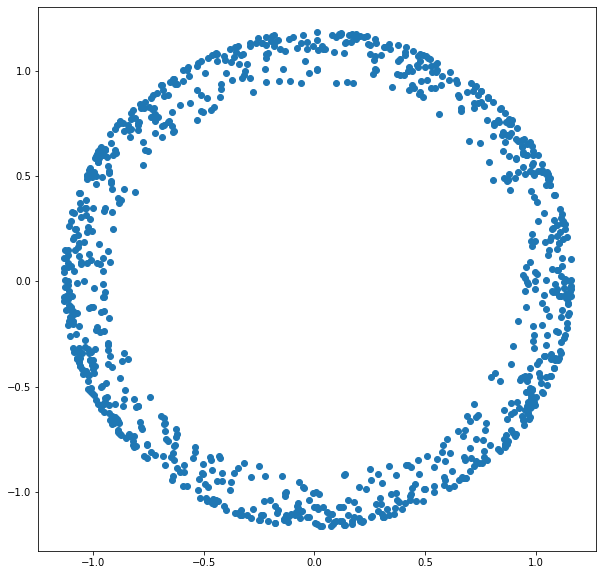

In [5]:
gammas = [0.1, 1, 2, 3, 6, 10, 30, 100]

for gamma in gammas:
    pca = KernelPCA(2, kernel='sigmoid', gamma=gamma)

    orig_points = generate_cylinder(1000)
    points = pca.fit_transform(orig_points)

    print('Gamma = {}'.format(gamma))
    
    plt.figure(figsize=(10, 10))

    plt.scatter(points[:, 0], points[:, 1])
    plt.show()

### Now we can calculate the distances

In [6]:
def calc_distance(points_0, points_1):
    pers_0 = ripser.ripser(points_0)
    pers_1 = ripser.ripser(points_1)

    return persim.wasserstein(
        np.concatenate((pers_0['dgms'][0][:-1], pers_0['dgms'][1]), axis=0),
        np.concatenate((pers_1['dgms'][0][:-1], pers_1['dgms'][1]), axis=0)
    )

def calc_distances(gammas, n_points=100):
    results = []
    for gamma in gammas:
        pca = KernelPCA(2, kernel='sigmoid', gamma=gamma)
        
        points_3d = generate_cylinder(n_points)
        points_2d = pca.fit_transform(points_3d)
        
        results.append(calc_distance(points_3d, points_2d))
                       
    return results

In [7]:
distances_list = []
for _ in range(10):
    distances_list.append(calc_distances(gammas, n_points=100))
    
distances = np.array(distances_list)

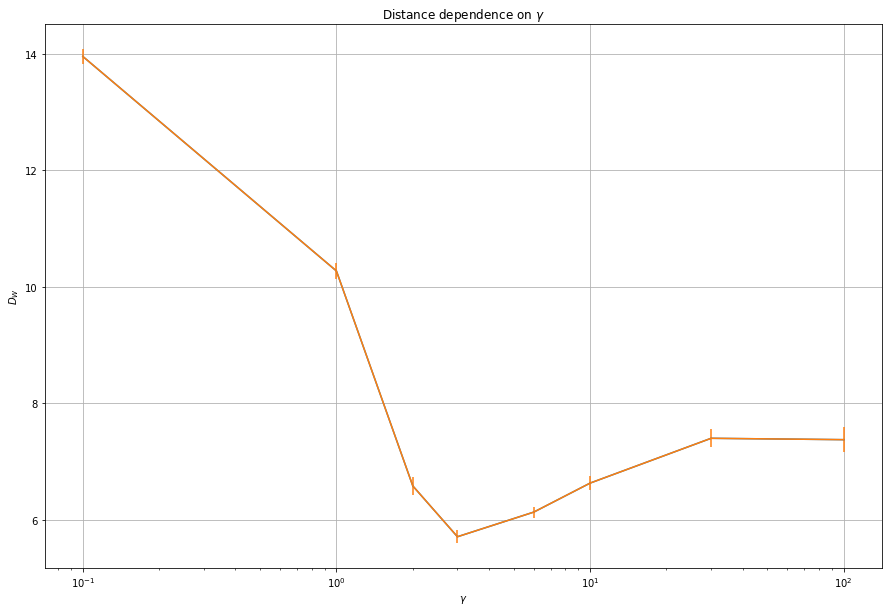

In [8]:
plt.figure(figsize=(15, 10))

plt.semilogx(gammas, distances.mean(axis=0))
plt.errorbar(gammas, distances.mean(axis=0), yerr=distances.std(axis=0) / distances.shape[0] ** 0.5)

plt.grid()

plt.title(r'Distance dependence on $\gamma$')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$D_W$')

plt.show()

### We can compare the minimal value with the distance for linear PCA

In [9]:
pca = KernelPCA(2)

distances = []
for _ in range(10):
    points_3d = generate_cylinder(100)
    points_2d = pca.fit_transform(points_3d)
    
    distances.append(calc_distance(points_3d, points_2d))
    
distances = np.array(distances)

print('Linear PCA distance = {} +- {}'.format(distances.mean(), distances.std() / distances.shape[0] ** 0.5))

Linear PCA distance = 9.892677529517199 +- 0.25471771841281826


### Here we will analyse the robustness

In [10]:
new_gammas = np.linspace(2, 6, 20)

distances_list = []
for _ in range(20):
    distances_list.append(calc_distances(new_gammas, n_points=100))
    
distances = np.array(distances_list)

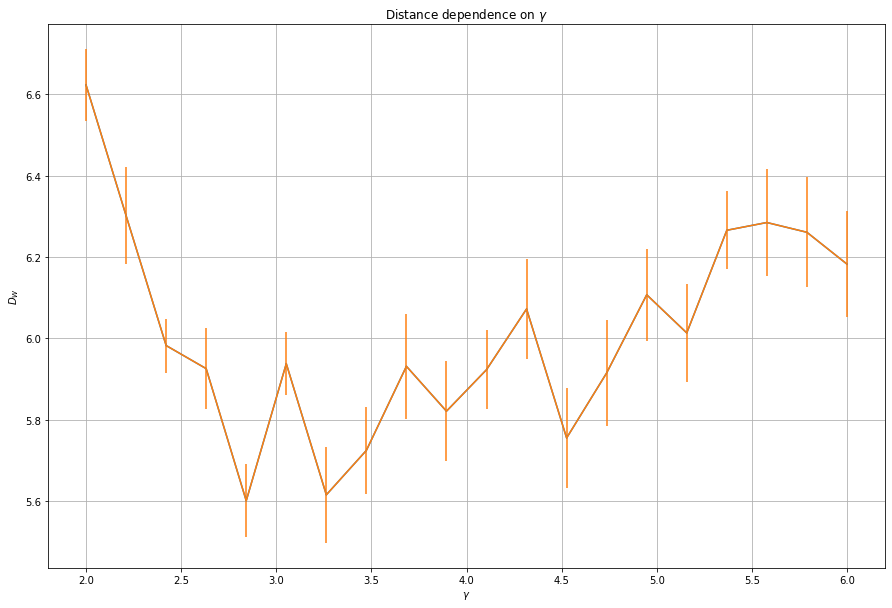

In [11]:
plt.figure(figsize=(15, 10))

plt.plot(new_gammas, distances.mean(axis=0))
plt.errorbar(new_gammas, distances.mean(axis=0), yerr=distances.std(axis=0) / distances.shape[0] ** 0.5)

plt.grid()

plt.title(r'Distance dependence on $\gamma$')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$D_W$')

plt.show()

In [12]:
gamma = 4
pca = KernelPCA(2, kernel='sigmoid', gamma=gamma)

distances_list = []
for _ in range(10):
    distances = []
    
    for sigma in np.linspace(0, 1, 10):
        points_3d = generate_cylinder(100, noise=sigma)
        points_2d = pca.fit_transform(points_3d)

        distances.append(calc_distance(points_3d, points_2d))
        
    distances_list.append(distances)
    
distances = np.array(distances_list)

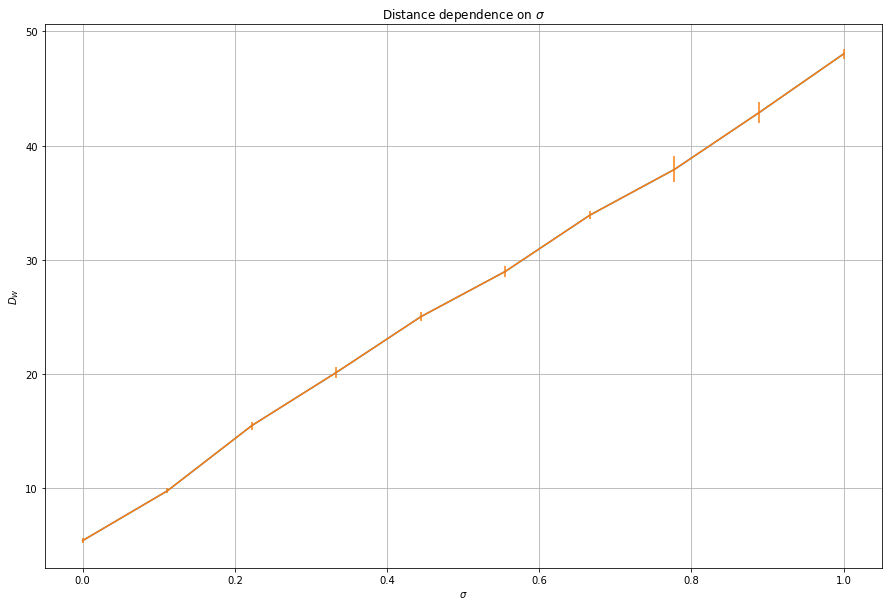

In [13]:
plt.figure(figsize=(15, 10))

plt.plot(np.linspace(0, 1, 10), distances.mean(axis=0))
plt.errorbar(np.linspace(0, 1, 10), distances.mean(axis=0), yerr=distances.std(axis=0) / distances.shape[0] ** 0.5)

plt.grid()

plt.title(r'Distance dependence on $\sigma$')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$D_W$')

plt.show()

In [14]:
gamma = 4
pca = KernelPCA(2, kernel='sigmoid', gamma=gamma)

distances_list = []
for _ in range(10):
    distances = []
    
    for sigma in np.linspace(0, 0.1, 10):
        points_3d = generate_cylinder(100, noise=sigma)
        points_2d = pca.fit_transform(points_3d)

        distances.append(calc_distance(points_3d, points_2d))
        
    distances_list.append(distances)
    
distances = np.array(distances_list)

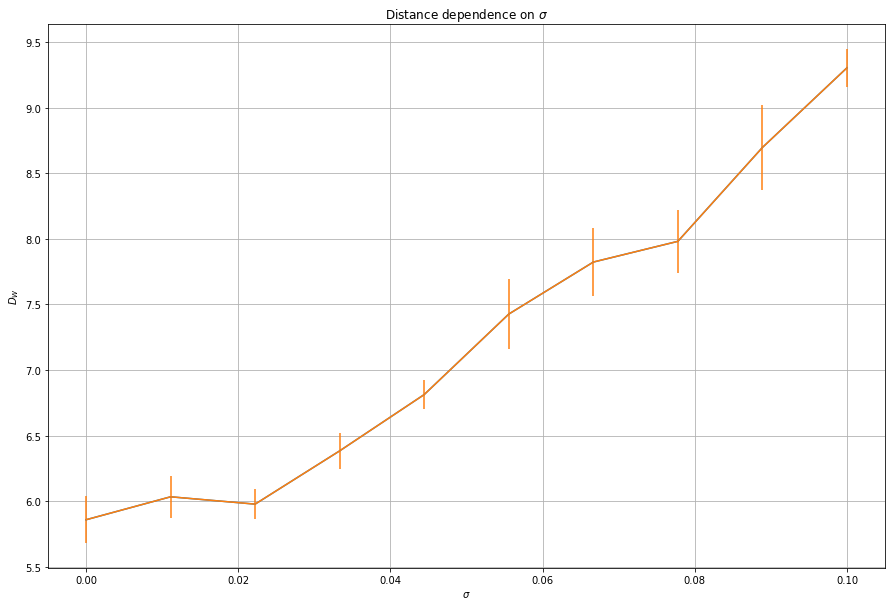

In [15]:
plt.figure(figsize=(15, 10))

plt.plot(np.linspace(0, 0.1, 10), distances.mean(axis=0))
plt.errorbar(np.linspace(0, 0.1, 10), distances.mean(axis=0), yerr=distances.std(axis=0) / distances.shape[0] ** 0.5)

plt.grid()

plt.title(r'Distance dependence on $\sigma$')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$D_W$')

plt.show()

C:\Users\test\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=100, n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
LLE: 1 sec
LTSA: 0.91 sec
Hessian LLE: 1.5 sec
Modified LLE: 1.5 sec
Isomap: 1.4 sec
MDS: 2.8 sec
SE: 0.11 sec
t-SNE: 2.6 sec


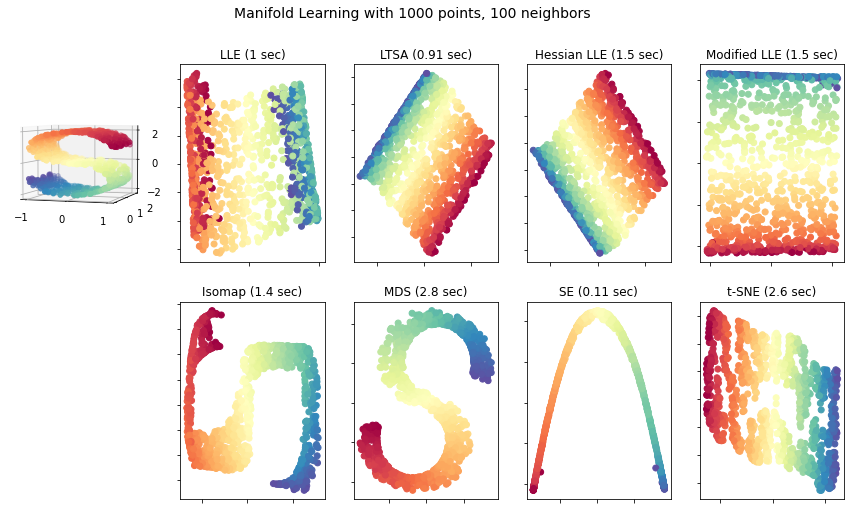

In [17]:
from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)
n_neighbors = 100
n_components = 2

# Create figure
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# Add 3d scatter plot
ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='auto')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()